In [ ]:
# Downloading LibriSpeech Dataset
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!wget https://www.openslr.org/resources/12/train-other-500.tar.gz

In [ ]:
# Download LibriSpeech dev dataset
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz
#!wget https://www.openslr.org/resources/12/dev-other.tar.gz

In [ ]:
import tarfile

# Extract 'train-clean-100.tar.gz'
with tarfile.open('dev-clean.tar.gz', 'r:gz') as tar:
    tar.extractall('LibriSpeech/dev-clean')

"""
# Extract 'train-other-500.tar.gz'
with tarfile.open('train-other-500.tar.gz', 'r:gz') as tar:
    tar.extractall('LibriSpeech/dev-other')
"""

In [2]:
import os

# Gather audio file paths and transcriptions
dataset = []

for root, dirs, files in os.walk("LibriSpeech"):
    for file in files:
        if file.endswith(".flac"):
            audio_path = os.path.join(root, file)
            transcript_path = os.path.join(root, file.replace(".flac", ".txt"))
            dataset.append((audio_path, transcript_path))
print(dataset[0][0])

LibriSpeech/segments/noisy/LibriSpeech/segments/noisy/652/130726/652-130726-0009_seg_0.flac


In [1]:
from pydub import AudioSegment
import numpy as np
import os
import math

def add_noise_to_audio(audio, noise_level=0.02):

    # Convert audio to numpy array (pydub uses raw audio)
    samples = np.array(audio.get_array_of_samples())
    
    # Generate random noise
    noise = np.random.normal(0, noise_level * np.max(samples), samples.shape).astype(samples.dtype)
    
    # Add noise to the audio signal
    noisy_samples = samples + noise
    noisy_samples = np.clip(noisy_samples, -32768, 32767)  # Ensure values are within int16 range
    
    # Convert numpy array back to AudioSegment
    noisy_audio = AudioSegment(
        noisy_samples.tobytes(),
        frame_rate=audio.frame_rate,
        sample_width=audio.sample_width,
        channels=audio.channels
    )
    
    return noisy_audio


def add_noise(audio) : 
    audio_np = np.array(audio.get_array_of_samples())
    P_signal = audio_np.std()**2    # Power of the signal
    SNR_dB = np.random.uniform(-5,15)
    P_noise = P_signal * 10**(-SNR_dB / 10)
    noise = np.sqrt(P_noise) * np.random.randn(len(audio_np))

    n_audio = audio_np + noise

    n_audio = np.clip(n_audio, -2**15, 2**15 - 1)  # for 16-bit PCM audio

    noisy_audio = AudioSegment(
        n_audio.astype(np.int16).tobytes(),
        frame_rate=audio.frame_rate,
        sample_width=audio.sample_width,
        channels=audio.channels
    )
    
    return noisy_audio  


def split_or_pad_audio(file_path, output_dir, segment_duration=5000):
    # Load the audio file
    audio = AudioSegment.from_file(file_path, format="flac")
    audio_length = len(audio)
    
    # Calculate the number of 5-second segments
    num_segments = math.ceil(audio_length / segment_duration)
    
    segments = []
    for i in range(num_segments):
        start = i * segment_duration
        end = start + segment_duration
        segment = audio[start:end]
        
        # If segment is less than 5 seconds, pad with silence
        if len(segment) < segment_duration:
            segment = segment + AudioSegment.silent(duration=(segment_duration - len(segment)))
        
        # Define the output file path
        segment_filename = f"{os.path.splitext(os.path.basename(file_path))[0]}_seg_{i}.flac"
        segment_path = os.path.join(output_dir, segment_filename)
    

        noisy_seg = add_noise(segment)
        noisy_path = segment_path.replace("clean","noisy")
        noisy_dir = os.path.dirname(noisy_path)
        os.makedirs(noisy_dir, exist_ok=True)
        noisy_seg.export(noisy_path, "flac")
        
        # Export the segment
        segment.export(segment_path, format="flac")
        segments.append(segment_path)

    
    return segments

In [ ]:
nossy_aud = add_noise_to_audio(dataset[0][0], 0.05)
audio = AudioSegment.from_file(dataset[0][0], format="flac")
print(len(audio))

# Define the output file path
output_dir = "LibriSpeech_test"  
os.makedirs(output_dir, exist_ok=True)
filename= f"{os.path.basename(dataset[0][0])}".replace(".flac",".wav")
print(filename)
path = os.path.join(output_dir, filename)

filename_noisy = f"{os.path.splitext(os.path.basename(dataset[0][0]))[0]}_noisy.wav"
path_noisy = os.path.join(output_dir, filename_noisy)
print(path_noisy)

# Export the segment
audio.export(path, format="wav")
nossy_aud.export(path_noisy, format="wav")

In [14]:
output_dir = "LibriSpeech_test_chop"
os.makedirs(output_dir, exist_ok=True)
print(dataset[0][0])
segment_list = split_or_pad_audio(dataset[0][0],output_dir,5000)
print(segment_list[0])

LibriSpeech/dev-clean/LibriSpeech/dev-clean/652/130726/652-130726-0024.flac
LibriSpeech_test_chop/652-130726-0024_seg_0.wav


In [ ]:
# Spliting Audios 5 seconds

import math
import os

# Gather audio file paths and transcriptions
dataset = []
count = 0
max_files = 10

for root, dirs1, files in os.walk("LibriSpeech/dev-clean"):
    for file in files:
        if file.endswith(".flac"):
            audio_path = os.path.join(root, file)
            output_dir = os.path.dirname(audio_path.replace("dev-clean", "segments/clean"))
            os.makedirs(output_dir, exist_ok=True)
            segment_list = split_or_pad_audio(audio_path,output_dir,5000)
            for segment in segment_list:
                clean_path = segment
                noisy_path = clean_path.replace("clean", "noisy")
                dataset.append((noisy_path, segment))
            count += 1
            if count >= max_files:
                break
    if count >= max_files:
        break



In [6]:
print(dataset[0][0])
print(dataset[0][1])
naudio = AudioSegment.from_file(dataset[0][0],"flac")
caudio = AudioSegment.from_file(dataset[0][1],"flac")

naudio.export("naudio.wav","wav")
caudio.export("caudio.wav","wav")


LibriSpeech/segments/noisy/LibriSpeech/segments/noisy/652/130726/652-130726-0024_seg_0.flac
LibriSpeech/segments/clean/LibriSpeech/segments/clean/652/130726/652-130726-0024_seg_0.flac


<_io.BufferedRandom name='caudio.wav'>

In [8]:
# Transform to spectogram 
import librosa

def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes a audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    
    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase
 
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audio of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    # we extract the magnitude vectors from the 256-point STFT vectors and 
    # take the first 129-point by removing the symmetric half.

    nb_audio = numpy_audio.shape[0]
    # dim_square_spec = 256/2
    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

In [16]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def compute_spectrogram(file_path, display=False):
    """
    Compute the spectrogram of an audio file.
    
    Parameters:
    - file_path: str, path to the .flac audio file
    - display: bool, if True, displays the spectrogram
    
    Returns:
    - S_dB: np.ndarray, decibel-scaled spectrogram
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=16000)
    
    # Compute Short-Time Fourier Transform (STFT)
    S = librosa.stft(y,1024,512)
    S_phase = np.angle(S)
    
    # Convert amplitude to dB for a better visualization scale
    S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Display the spectrogram if needed
    if display:
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
        plt.colorbar(format="%+2.0f dB")
        plt.title("Spectrogram")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.show()
    
    return S_dB, S_phase

In [ ]:
s_db, p1 = compute_spectrogram(dataset[0][0],True)
s2_db, p2 = compute_spectrogram(dataset[0][1],True)

(1025, 157)


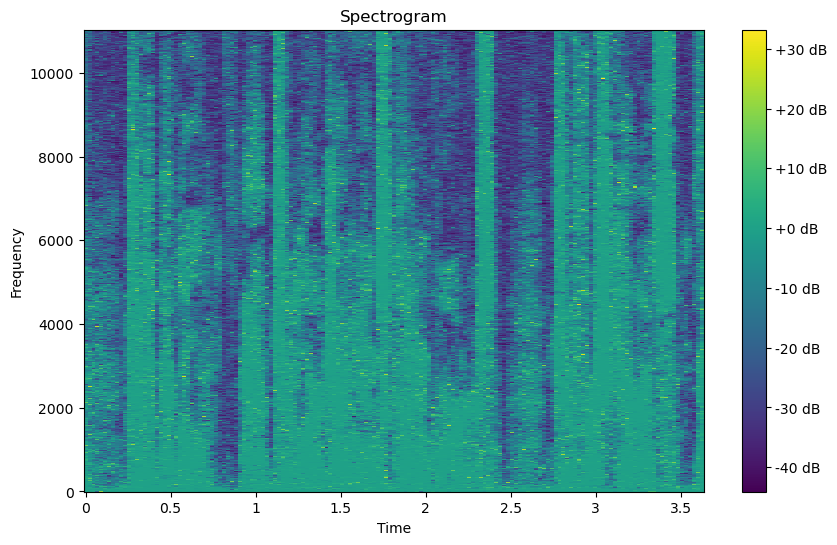

<_io.BufferedRandom name='test.wav'>

In [15]:
print(s2_db.shape)

sf = s2_db-s_db
plt.figure(figsize=(10, 6))
librosa.display.specshow(sf, sr=22050, x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

# Step 1: Convert dB back to amplitude
S_linear = librosa.db_to_amplitude(sf)

# Step 2: Combine amplitude with phase to get the complex-valued spectrogram
S_complex = S_linear * np.exp(1j * np.angle(p1))

# Step 3: Perform the inverse STFT to get back the time-domain signal
y_reconstructed = librosa.istft(S_complex, hop_length=512)

y_reconstructed_int16 = np.int16(y_reconstructed / np.max(np.abs(y_reconstructed)) * 32767)
audio_segment = AudioSegment(
    y_reconstructed_int16.tobytes(), 
    frame_rate=16000, 
    sample_width=2,  # 2 bytes for 16-bit audio
    channels=1       # Mono audio
)

audio_segment.export("test.wav", format="wav")


In [ ]:
import librosa
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, metadata_file):
        """
        Args:
            metadata_file (str): Path to the file with audio file paths and labels.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.metadata = pd.read_csv(metadata_file, names=['noisy_path', 'clean_path'], skiprows=1)  

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Retrieve file paths for noisy and clean audio
        noisy_path = self.metadata.iloc[idx]['noisy_path']
        clean_path = self.metadata.iloc[idx]['clean_path']
        
        # Load audio and calculate spectrogram from clean and noisy audio
        y_noisy, sr = librosa.load(noisy_path, sr=None)
        if not isinstance(y_noisy, np.ndarray):
           y_noisy = np.array(y_noisy)
        S_noisy = librosa.stft(y_noisy, n_fft=2048, hop_length=256)
        S_dB_noisy = librosa.amplitude_to_db(np.abs(S_noisy), ref=np.max)

        y_clean, sr = librosa.load(clean_path, sr=None)
        if not isinstance(y_clean, np.ndarray):
            y_clean = np.array(y_clean)
        S_clean = librosa.stft(y_clean, n_fft=2048, hop_length=256)
        S_dB_clean = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
        
        # Convert to tensor
        S_dB_noisy = torch.tensor(S_dB_noisy, dtype=torch.float32)
        S_dB_clean = torch.tensor(S_dB_clean, dtype=torch.float32)
        
        return S_dB_noisy, S_dB_clean


v2

In [ ]:
import librosa
import numpy as np
import os
import math

SAMPLE_RATE = 16000

def add_noise(audio) : 
    P_signal = audio.std()**2    # Power of the signal
    SNR_dB = np.random.uniform(-5,15)
    P_noise = P_signal * 10**(-SNR_dB / 10)
    noise = np.sqrt(P_noise) * np.random.randn(len(audio))

    n_audio = audio + noise

    n_audio = np.clip(n_audio, -2**15, 2**15 - 1)  # for 16-bit PCM audio

    
    return n_audio  


def split_or_pad_audio(file_path, segment_duration=5000):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    audio_length = len(audio)
    
    # Calculate the number of 5-second segments
    samples_duration = int((segment_duration/1000)*SAMPLE_RATE)
    num_segments = math.ceil(len(audio)/samples_duration)
    print("Len de audio es :", len(audio), "por tatno ", num_segments, "segmentos")
    
    segments = []
    for i in range(num_segments):
        start = i * samples_duration
        end = start + samples_duration
        segment = audio[start:end]
        
        if len(segment) < samples_duration:
            padding = np.zeros(samples_duration - len(segment))
            segment = np.concatenate([segment, padding])
            
        segments.append((add_noise(segment),segment))

    return segments



In [31]:
combined_segments = split_or_pad_audio("LibriSpeech/dev-clean/LibriSpeech/dev-clean/652/130726/652-130726-0024.flac", segment_duration=5000)
print(f"Clean is {combined_segments[0][1]} and noisy is {combined_segments[0][0]}")

Len de audio es : 171760 por tatno  3 segmentos
Clean is [-0.03222656 -0.03356934 -0.03573608 ...  0.09552002  0.07519531
  0.0670166 ] and noisy is [-0.0223915  -0.01735666 -0.02659798 ...  0.08256957  0.0859496
  0.07119398]


In [33]:

import soundfile as sf

sf.write('naudio.wav',combined_segments[1][0] , SAMPLE_RATE)
sf.write('caudio.wav',combined_segments[1][1] , SAMPLE_RATE)

In [46]:
# Spliting Audios 5 seconds

import math
import os

# Gather audio file paths and transcriptions
audio_tuple = []
count = 0
max_files = 10

for root, dirs1, files in os.walk("LibriSpeech/dev-clean"):
    for file in files:
        if file.endswith(".flac"):
            audio_path = os.path.join(root, file)
            segment_tuple = split_or_pad_audio(audio_path,5000)
            audio_tuple.extend(segment_tuple)
            count += 1
            if count >= max_files:
                break
    if count >= max_files:
        break


Len de audio es : 171760 por tatno  3 segmentos
Len de audio es : 48320 por tatno  1 segmentos
Len de audio es : 98160 por tatno  2 segmentos
Len de audio es : 91920 por tatno  2 segmentos
Len de audio es : 84800 por tatno  2 segmentos
Len de audio es : 106880 por tatno  2 segmentos
Len de audio es : 61360 por tatno  1 segmentos
Len de audio es : 101840 por tatno  2 segmentos
Len de audio es : 148880 por tatno  2 segmentos
Len de audio es : 197840 por tatno  3 segmentos


In [56]:
print(len(segment_tuple))
print((audio_tuple))


3
[(array([ 0.13549843, -0.1239909 ,  0.01206448, ...,  0.0327022 ,
        0.16355607,  0.17818759]), array([-0.03222656, -0.03356934, -0.03573608, ...,  0.09552002,
        0.07519531,  0.0670166 ], dtype=float32)), (array([ 0.03435568,  0.13383588,  0.02696181, ...,  0.01052111,
        0.00606188, -0.1092658 ]), array([ 0.05987549,  0.06082153,  0.0664978 , ..., -0.01074219,
       -0.01016235, -0.01159668], dtype=float32)), (array([-0.01096871, -0.01910759, -0.00785846, ...,  0.00958032,
        0.00562253,  0.00020033]), array([-0.01333618, -0.01385498, -0.0163269 , ...,  0.        ,
        0.        ,  0.        ])), (array([ 0.00131953,  0.00267885,  0.01681942, ..., -0.01760332,
       -0.00132873,  0.00128356]), array([0.00183105, 0.00183105, 0.00177002, ..., 0.        , 0.        ,
       0.        ])), (array([ 0.02299447,  0.0063748 , -0.01603419, ..., -0.10438963,
       -0.07467012, -0.03340173]), array([-0.00250244, -0.00259399, -0.00253296, ..., -0.0916748 ,
       -0

In [59]:
import librosa
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio_data):
        """
        Args:
            metadata_file (str): Path to the file with audio file paths and labels.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.audio_data = audio_data  

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        
        noisy_audio, clean_audio = self.audio_data[idx]
        # Load audio and calculate spectrogram from clean and noisy audio
        S_noisy = librosa.stft(noisy_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_noisy = librosa.amplitude_to_db(np.abs(S_noisy), ref=np.max)

        S_clean = librosa.stft(clean_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_clean = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
        
        # Convert to tensor
        S_dB_noisy = torch.tensor(S_dB_noisy, dtype=torch.float32)
        S_dB_clean = torch.tensor(S_dB_clean, dtype=torch.float32)
        
        return S_dB_noisy, S_dB_clean

In [60]:
from torch.utils.data import DataLoader

audio_dataset = AudioDataset(audio_tuple)
audio_dataloader = DataLoader(audio_dataset, batch_size=5, shuffle=True)

# Iterate through the DataLoader
for noisy_batch, clean_batch in audio_dataloader:
    print(f"Noisy batch shape: {noisy_batch.shape}")
    print(f"Clean batch shape: {clean_batch.shape}")

Noisy batch shape: torch.Size([5, 257, 501])
Clean batch shape: torch.Size([5, 257, 501])
Noisy batch shape: torch.Size([5, 257, 501])
Clean batch shape: torch.Size([5, 257, 501])
Noisy batch shape: torch.Size([5, 257, 501])
Clean batch shape: torch.Size([5, 257, 501])
Noisy batch shape: torch.Size([5, 257, 501])
Clean batch shape: torch.Size([5, 257, 501])


In [ ]:
import numpy as np
import librosa
import torch

# Signal parameters
duration = 5.0  # seconds
num_samples = 256
fs = num_samples / duration  # Sampling rate
window_size = 400
hop_length = 160

# Generate a dummy signal (replace with your signal)
time = np.linspace(0, duration, num_samples, endpoint=False)
signal = np.sin(2 * np.pi * 50 * time)  # 5 Hz sine wave

# Calculate spectrogram using librosa
S = librosa.stft(signal, n_fft=window_size, hop_length=hop_length, window='hann')
amplitude_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Convert amplitude_db to power
amplitude_power = 10**(amplitude_db / 10)

# Calculate correction factor
window = np.hanning(window_size)  # Use the same Hann window
window_energy = np.sum(window**2)  # Sum of squared window coefficients
overlap_factor = window_size / hop_length  # Overlap factor
correction_factor = window_energy * overlap_factor

# Total power
total_power = 10*np.log10(np.sum(amplitude_power) / correction_factor)

print(f"Total power of the signal: {total_power:.4f}")


Total power of the signal: -20.8546


In [6]:
import numpy as np

from fe import preemphasis, offset, windowing2

def compute_vad(x, fs=16000, N=0.025, M=0.010, nfft=512):
    maxamplitude, th, lambd, n, coef_floor, alpha  = 0.75, 4, 0.6, 4, 0.22, 0.9
    x = maxamplitude * (x / (np.abs(x).max()))

    frame = int(N * fs)
    shift = int(M * fs)
    Nframes = int(1 + np.ceil((x.size-shift)/shift))

    x = preemphasis(offset(x))
    X = windowing2(x, fs, N, M) * np.hamming(frame)
    Xfft = np.abs(np.fft.fft(X, nfft))
    Xfft = Xfft[:, 1:int(nfft/2+1)]

    # init
    LTSE = np.zeros(Xfft.shape)
    r_est = np.zeros(Xfft.shape)
    r_lt = np.zeros(Xfft.shape)
    LTSD = np.zeros(Nframes)
    vad = np.zeros(Nframes)

    LTSE[0] = np.max(Xfft[0:n+1],axis=0)
    suelo = np.ones(int(nfft/2)) * (coef_floor * np.power(np.mean(Xfft), 2))
    r_est[0] = np.mean(np.power(Xfft[0:n],2),0)
    r_lt[0] = r_est[0]
    LTSD[0] = 10*np.log10(1/(nfft)*sum(np.power(LTSE[0],2)/r_est[0]))
    vad[0] = int(LTSD[0] > th)

    # LTSE & LTSD => vad
    for j in range(1,Nframes-1):
        a = np.max([j - n, 1])
        aa = np.min([j + n, Nframes + 1])
        LTSE[j] = np.max(Xfft[np.max([j-n, 0]):np.min([j+n, Nframes+1])+1],axis=0)

        if vad[j-1]:
            r_est[j] = r_est[j-1]
        else:
            r_est[j] = lambd*r_est[j-1]+(1-lambd)*np.power(Xfft[j],2) #MCRA sustituir...ver el de C

        r_lt[j] = alpha*r_lt[j-1]+(1-alpha)*np.min([np.power(Xfft[j],2),r_est[j]],0)
        LTSD[j] = 10*np.log10(1/(nfft)*sum(np.power(LTSE[j],2)/np.max([r_lt[j],suelo],0)))
        vad[j] = int(LTSD[j] > th)

    vadsamples = np.kron(vad, np.ones(shift))
    vadsamples = np.reshape(vadsamples, (1,np.product(vadsamples.shape)))[0]
    vadsamples = vadsamples[0:x.size]
    vadsamples = np.asarray(vadsamples, dtype=np.int16)

    return vadsamples, vad